# Mac Address Analysis

The mac addresss can be used to understand the type of devices held by the customer. A csv was downloaded from the official IEEE website which contains a list of the first 6 letters of the mac address and the company which they are associated with.

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
matplotlib.style.use('ggplot')

## Import the data and the mac addresses

In [37]:
COLUMNS_TO_IMPORT = ['mac_address', 'date_time', 'location', 'store_id', 'x', 'y']

shopper_df = pd.read_csv('../data/bag_mus_12-22-2016.csv', usecols=COLUMNS_TO_IMPORT)
shopper_df.date_time = shopper_df.date_time.astype('datetime64[ns]')

# signal_df = shopper_df[shopper_df['location'] == 'Home & Leisure']
signal_df = shopper_df[shopper_df['location'] == 'Mall of Mauritius']
# signal_df = shopper_df[shopper_df['location'] == 'Phoenix Mall']

In [38]:
mac_address_df = pd.read_csv('../data/mac_address_cross_reference.csv')

## Add manufacturer to signal_df

In [39]:
signal_df['mac_address_short'] = signal_df.mac_address.str.replace(':', '').str.upper().str[:6]
signal_df = signal_df.merge(mac_address_df, how='left', left_on='mac_address_short', right_on='Assignment')
signal_df.drop(['Registry', 'Assignment', 'Organization Address'], inplace=True, axis=1)
signal_df.rename(columns={'Organization Name': 'manufacturer'}, inplace=True)

c:\users\tvb\envs\venv-msci\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Manufacturer Analysis

In [40]:
signal_df.manufacturer.value_counts()[:30]

Samsung Electronics Co.,Ltd                                       791155
Apple, Inc.                                                       261269
HUAWEI TECHNOLOGIES CO.,LTD                                       194784
SAMSUNG ELECTRO-MECHANICS(THAILAND)                               162656
HTC Corporation                                                   142012
LG Electronics (Mobile Communications)                            108320
Murata Manufacturing Co., Ltd.                                     56911
Intel Corporate                                                    54493
Ruckus Wireless                                                    53352
Sony Mobile Communications AB                                      47437
Hon Hai Precision Ind. Co.,Ltd.                                    35920
Xiaomi Communications Co Ltd                                       33643
TCT mobile ltd                                                     25138
Microsoft Corporation                              

In [173]:
signal_df.groupby('mac_address').head(1).manufacturer.value_counts()[:30]

Samsung Electronics Co.,Ltd                                       17575
Apple, Inc.                                                        4727
SAMSUNG ELECTRO-MECHANICS(THAILAND)                                4649
HUAWEI TECHNOLOGIES CO.,LTD                                        3687
HTC Corporation                                                    3123
Motorola Mobility LLC, a Lenovo Company                            2769
LG Electronics (Mobile Communications)                             2754
Murata Manufacturing Co., Ltd.                                     1681
Sony Mobile Communications AB                                      1184
Nokia Corporation                                                   720
Microsoft Corporation                                               658
SAMSUNG ELECTRO MECHANICS CO., LTD.                                 571
TCT mobile ltd                                                      419
Ubiquiti Networks Inc.                                          

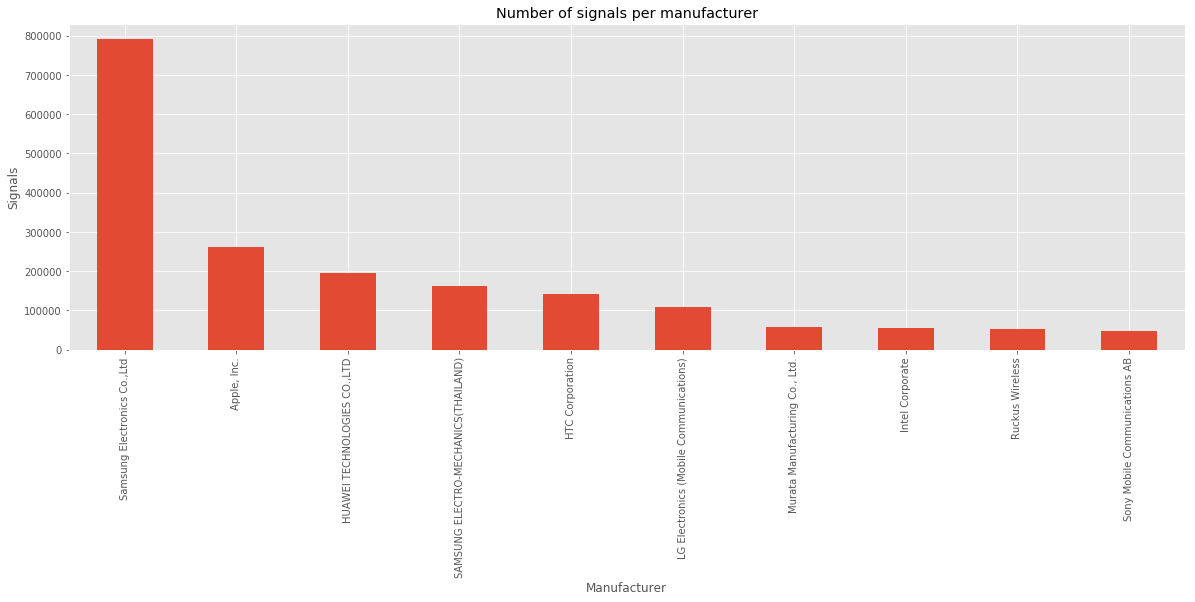

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
ax = signal_df.manufacturer.value_counts()[0:10].plot.bar(ax=axes)
ax.set_title('Number of signals per manufacturer')
ax.set_xlabel('Manufacturer')
ax.set_ylabel('Signals');

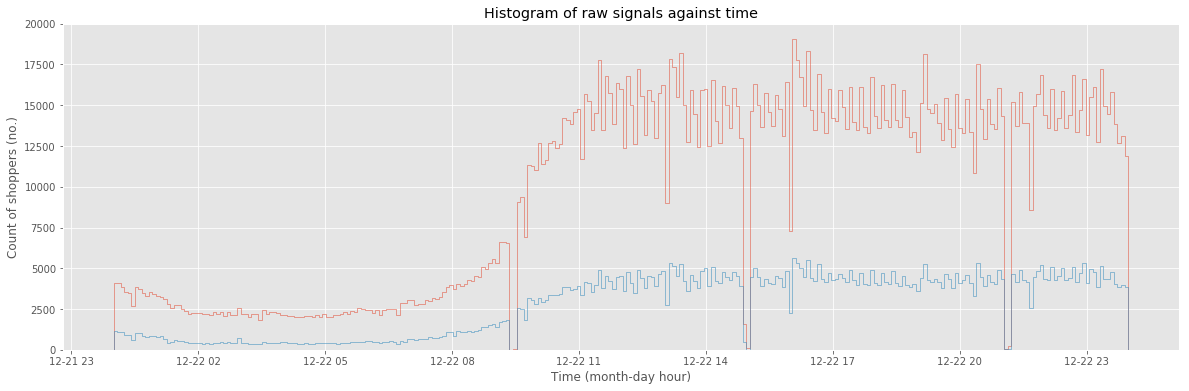

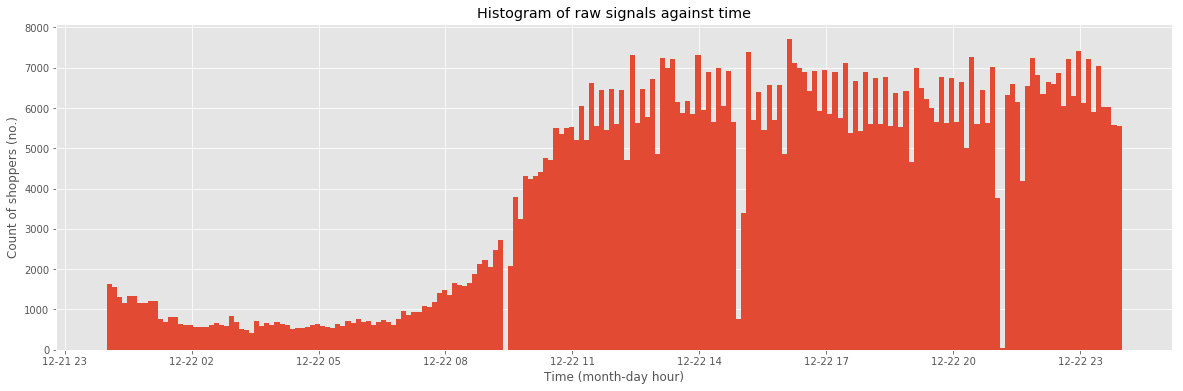

In [42]:
COMPANY = 'Samsung Electronics Co.,Ltd'

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))

signal_bins = int((signal_df.date_time.max() - signal_df.date_time.min()).seconds / (60 * 5))
signal_df.date_time.hist(bins=signal_bins, ax=axes, histtype='step')

company_signal_df = signal_df[signal_df.manufacturer == COMPANY]

company_bins = int((company_signal_df.date_time.max() - company_signal_df.date_time.min()).seconds / (60 * 5))
company_signal_df.date_time.hist(bins=company_bins, ax=axes, histtype='step')

axes.set_title('Histogram of raw signals against time')
axes.set_xlabel('Time (month-day hour)')
axes.set_ylabel('Count of shoppers (no.)')

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))

ax = company_signal_df.date_time.hist(bins=200, ax=axes)
ax.set_title('Histogram of raw signals against time')
ax.set_xlabel('Time (month-day hour)')
ax.set_ylabel('Count of shoppers (no.)');

## Mobile vs Stationary Devices

We have used two measures to determine whether the device was stationary or mobile. 

The first uses the standard deviation of the histogram of the date time to the nearest hour. The enables us to see where the devices are typically background or are just there during peak times.

The second uses the average of the standard deviation of the displacement of each mac address. The enables us to see where the device roams around the store or stays fixed to one location.

In [99]:
manufacturer = signal_df.manufacturer.value_counts()
manufacturer_df = pd.DataFrame(manufacturer)
manufacturer_df.rename(columns={'manufacturer': 'count'}, inplace=True)
manufacturer_df['manufacturer'] = manufacturer_df.index
manufacturer_df.reset_index(inplace=True, drop=True)

In [163]:
def add_date_time_std(row):
    print('*', end='')
    values = signal_df[signal_df.manufacturer == row.manufacturer].date_time.dt.round('60min').value_counts()
    return values.std()/np.sqrt(len(values))

def add_distance_std(row):
    print('*', end='')
    values = signal_df[signal_df.manufacturer == row.manufacturer].groupby('mac_address').describe()
    y_std = values.x['std'].mean()
    x_std = values.y['std'].mean()
    return np.mean([x_std, y_std])

In [156]:
manufacturer_df['date_time_std'] = manufacturer_df.apply(add_date_time_std, axis=1)

****************************************************************************************************************************************************************************************************************************************************************

In [166]:
manufacturer_df = manufacturer_df.sort_values('date_time_std', ascending=False)
manufacturer_df['distance_std'] = manufacturer_df[12:25].apply(add_distance_std, axis=1)

*************

In [172]:
manufacturer_df.sort_values('date_time_std', ascending=False).head(25)

,count,manufacturer,date_time_std,distance_std
0,791155,"Samsung Electronics Co.,Ltd",4261.330906,NaN
1,261269,"Apple, Inc.",1609.878479,NaN
3,162656,SAMSUNG ELECTRO-MECHANICS(THAILAND),949.714161,NaN
2,194784,"HUAWEI TECHNOLOGIES CO.,LTD",801.154115,NaN
4,142012,HTC Corporation,731.357997,NaN
5,108320,LG Electronics (Mobile Communications),590.631693,NaN
6,56911,"Murata Manufacturing Co., Ltd.",359.843916,NaN
7,54493,Intel Corporate,359.146755,NaN
9,47437,Sony Mobile Communications AB,284.563960,NaN
10,35920,"Hon Hai Precision Ind. Co.,Ltd.",197.260116,NaN


When ordering by the date time std, the obvious mobile devices seem to aggregate to the top of the list. THis seems to be somewhat reassumered by the distance standard deviation.